In [51]:
import numpy as np
import sys
import os
import pandas as pd
import random
from SALib.analyze import morris as morris_analyze


# Adjust the path to point to external/AlphaPEM
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.sampling.sampler import get_polarisation_curve_samples, build_fixed_parameters, sample_parameters, PARAMETER_RANGES
from src.analysis.sensitivity import generate_morris_samples, rescale_samples, apply_dependent_parameters, run_morris_analysis, plot_morris_grid, summarize_morris_results

In [52]:


dependent_parameter_names=['Pc_des']
samples_df, trajectories, problem = generate_morris_samples(PARAMETER_RANGES, dependent_parameter_names)

df = rescale_samples(samples_df, PARAMETER_RANGES)

dependent_parameters = [{'parameter_name': 'Pc_des',
                         'function': lambda Pa_des: (np.maximum(1.1e5, Pa_des - 0.5e5), np.maximum(1.1e5, Pa_des - 0.1e5)),
                         'dependent_param': 'Pa_des'}]
df = apply_dependent_parameters(df, dependent_parameters)



In [22]:
#df = get_polarisation_curve_samples(sampled_parameters=df.to_dict(orient='records'), fixed_parameters=build_fixed_parameters(), save_path="../data/raw/N10_levels4_seed42.pkl", save_every=10)
df = get_polarisation_curve_samples(sampled_parameters=df[0:1].to_dict(orient='records'), fixed_parameters=build_fixed_parameters(), save_path=None, save_every=10)


In [105]:
data = pd.read_pickle('../data/raw/N10_levels4_seed42.pkl')

In [55]:
morris_all = run_morris_analysis(samples_df, problem, output=data['Ucell'])


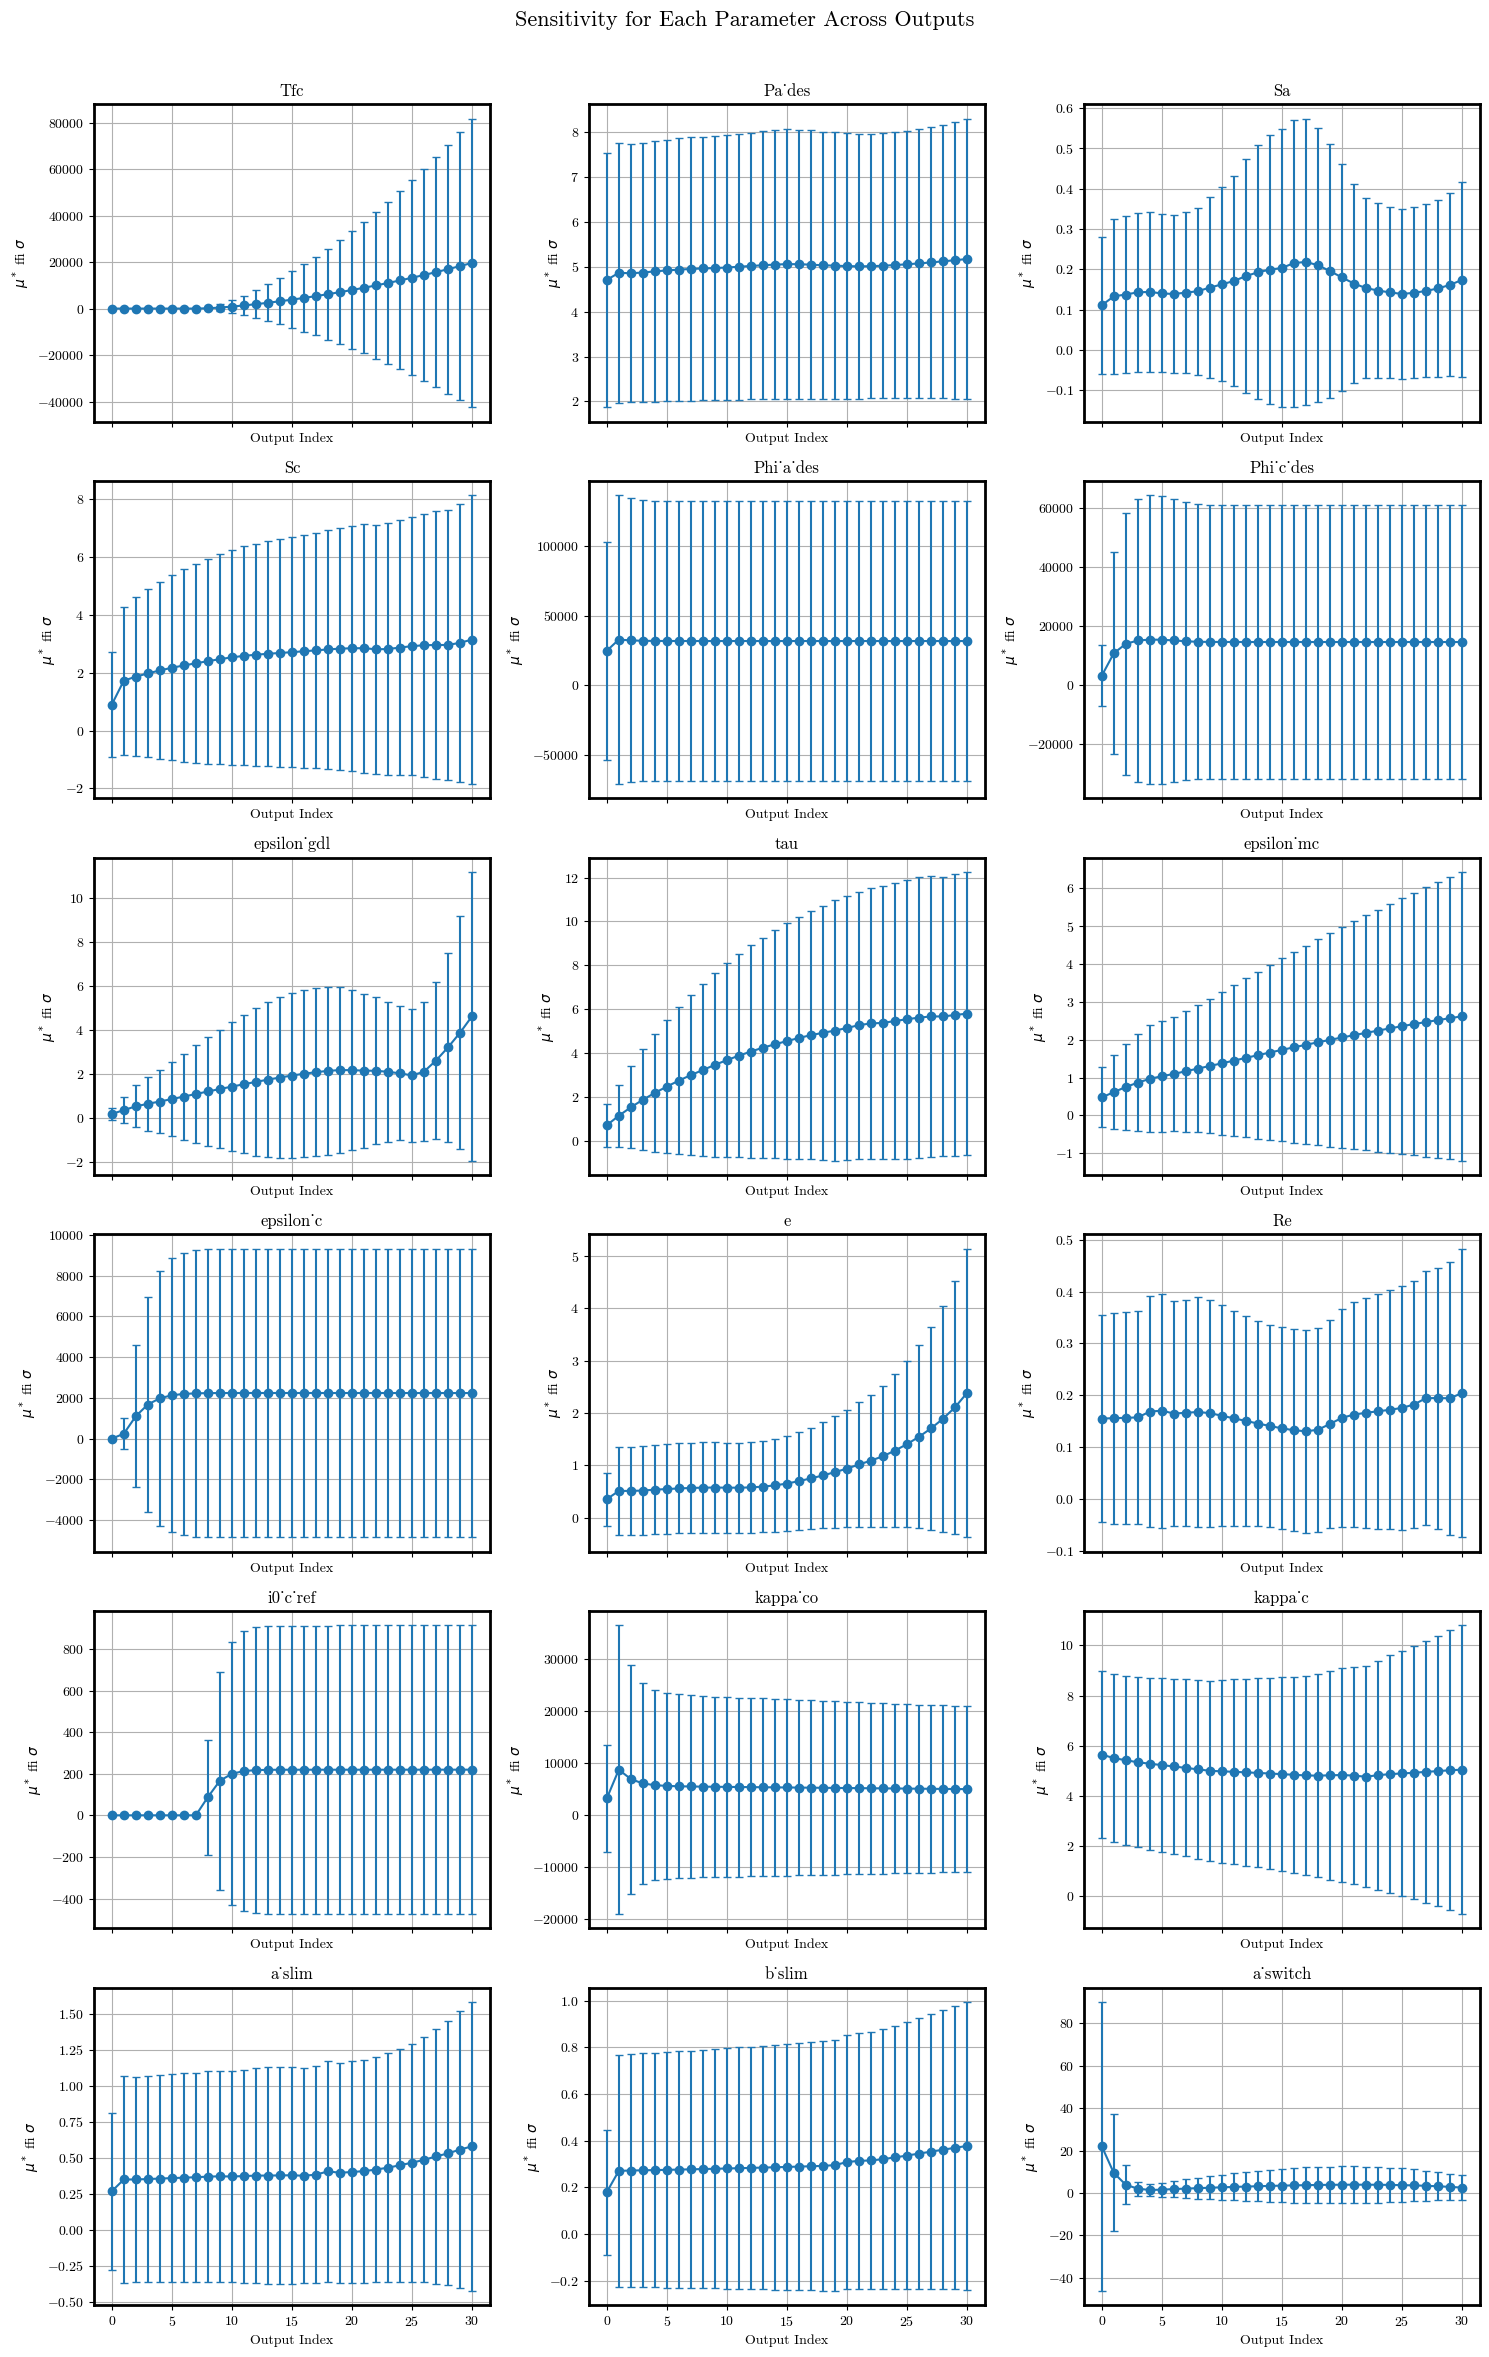

In [8]:
plot_morris_grid(morris_all, params=problem['names'], same_axis=False)

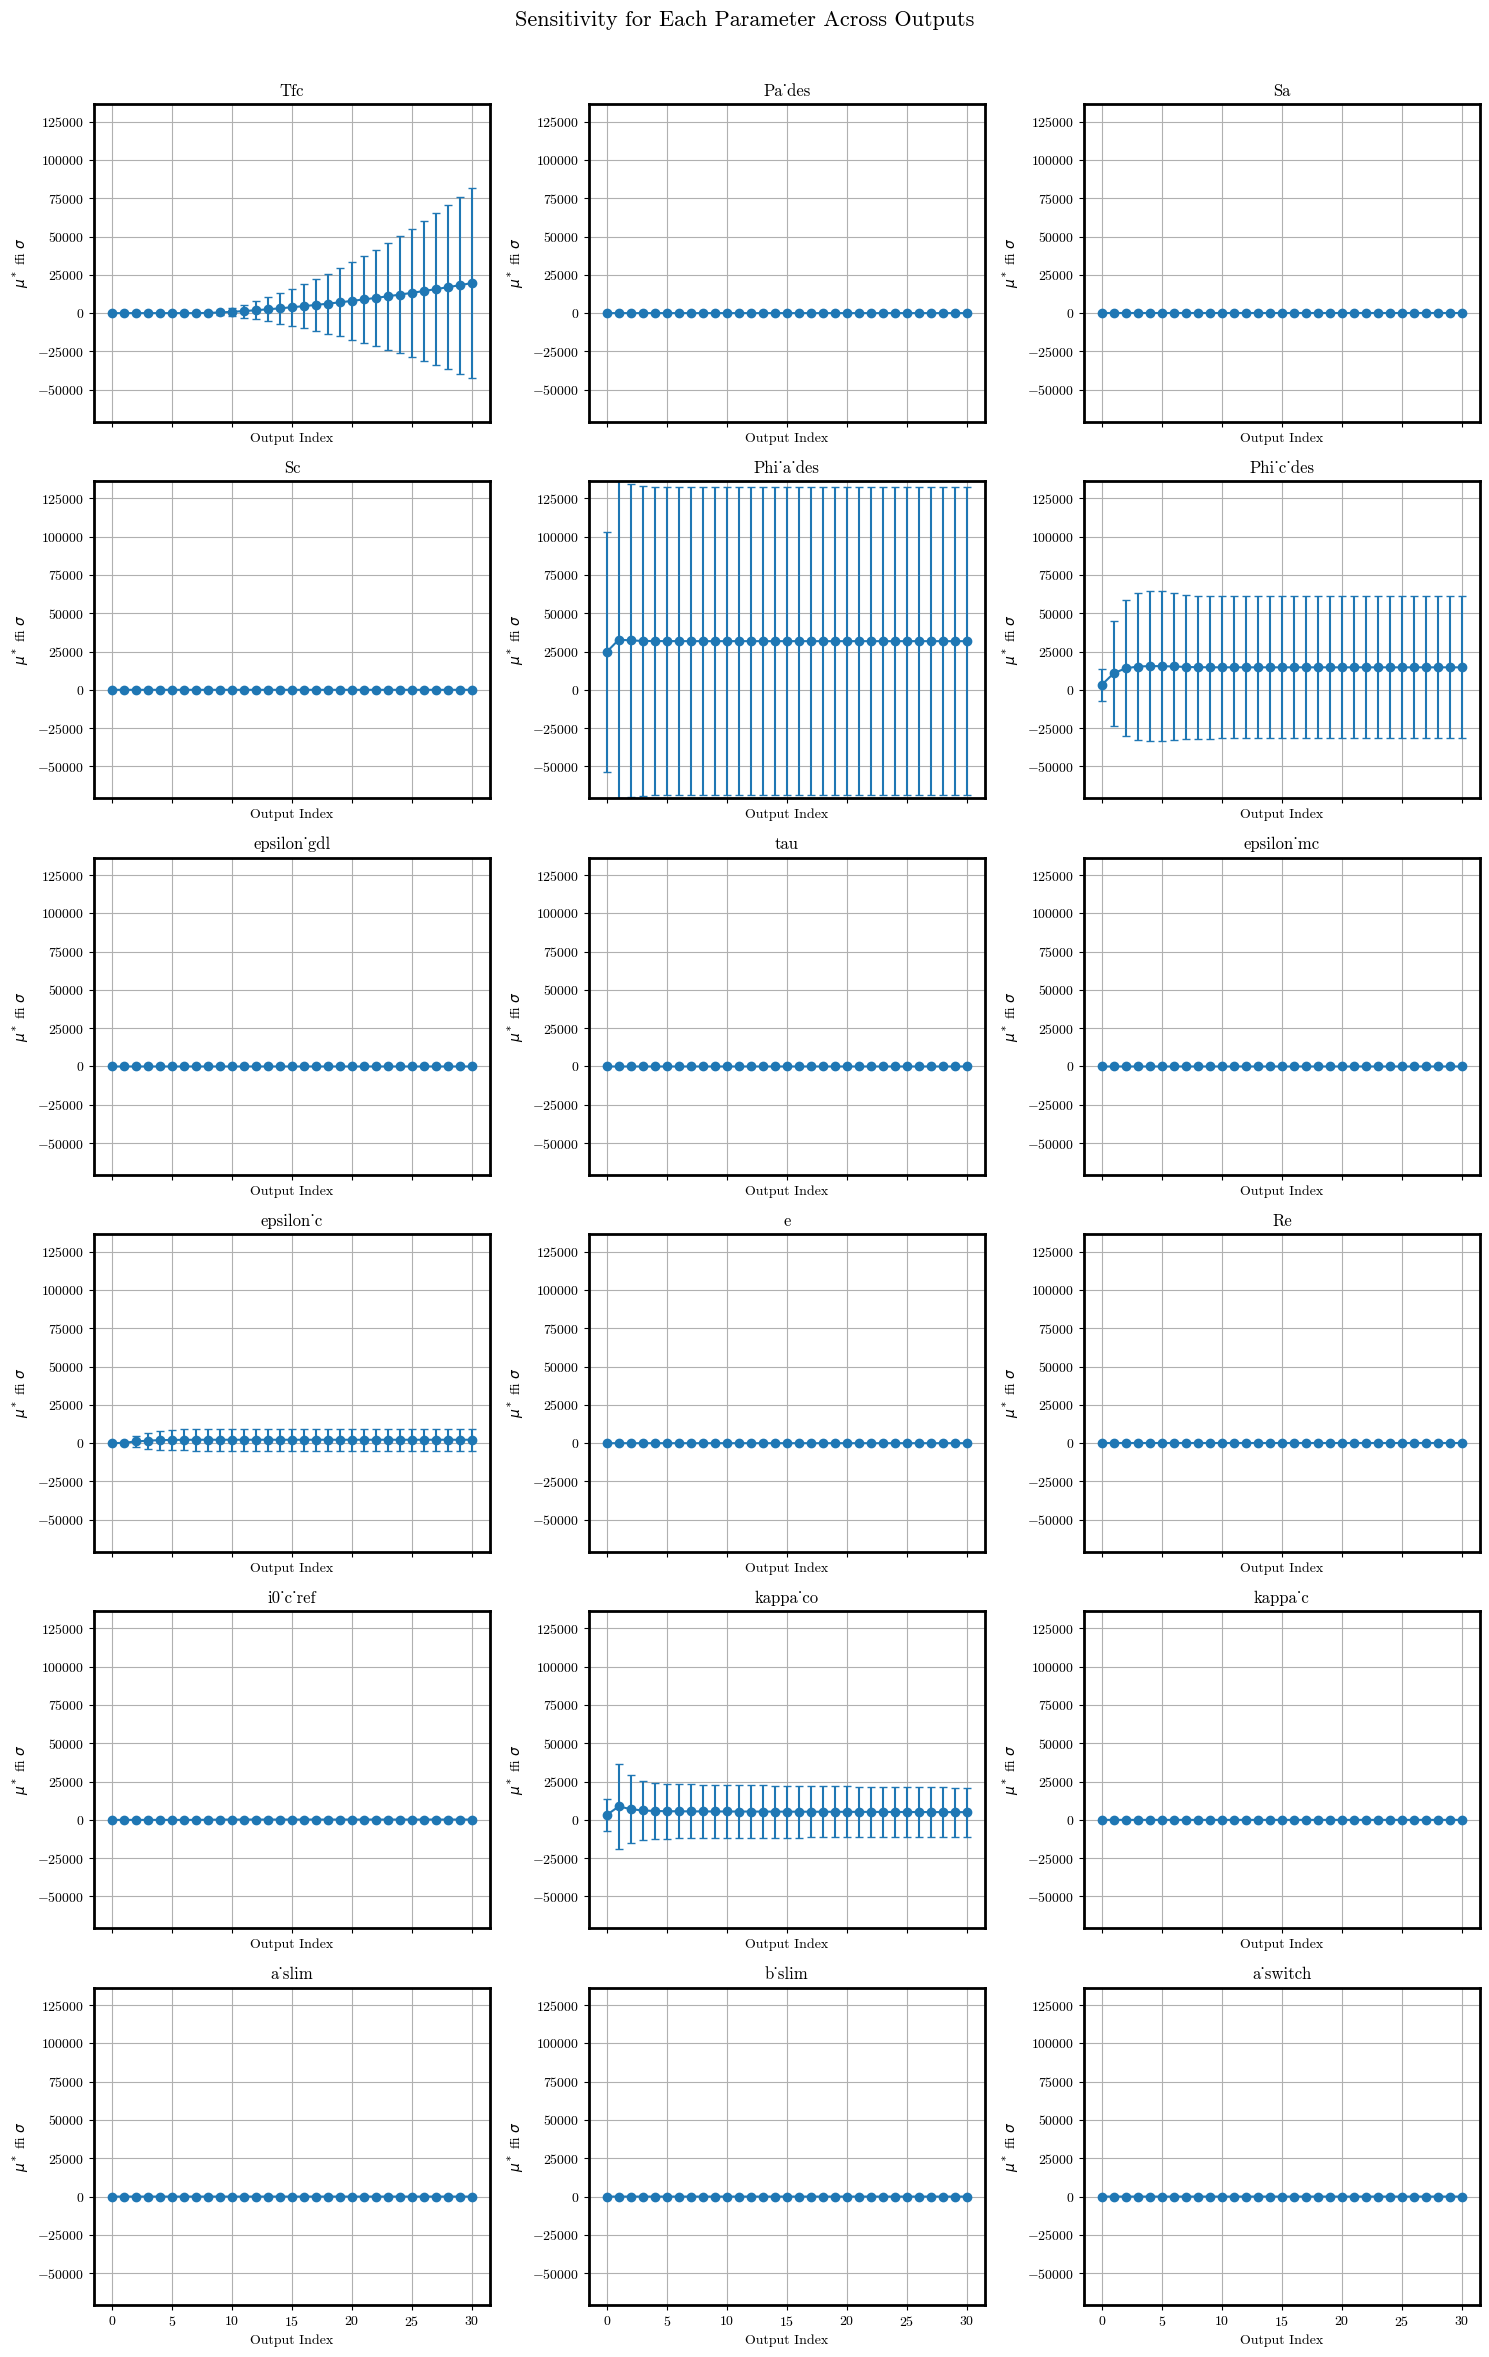

In [20]:
plot_morris_grid(morris_all, params=problem['names'], same_axis=True)


In [35]:
summarize_morris_results(morris_all, problem)

,Parameter,Mu*_mean,Mu*_std
0,Phi_a_des,31595.542477,1258.179368
1,Phi_c_des,14265.064501,2142.365122
2,Tfc,5979.956115,6249.471233
3,kappa_co,5453.908350,806.411341
4,epsilon_c,2032.426903,550.203692
5,i0_c_ref,156.351169,95.236062
6,kappa_c,5.018872,0.220099
7,Pa_des,4.995978,0.092853
8,tau,4.097631,1.478882
9,a_switch,3.912528,3.566454


In [108]:
data['AUC'] = data.apply(lambda row: np.trapezoid(row['Ucell'], row['ifc']), axis=1)

# Calculate simple sum of Ucell values
data['Ucell_sum'] = data['Ucell'].apply(np.sum)

def calculate_Ucell_sum(row):
    # Get the ifc value and Ucell list
    ifc = row['ifc']
    Ucell = row['Ucell']
    
    # Initialize sums for each region
    region_1_sum = 0
    region_2_sum = 0
    region_3_sum = 0
    
    for i in range(len(ifc)):
        if ifc[i] < 0.4:
            region_1_sum += Ucell[i]
        elif 0.4 <= ifc[i] < 1.6:
            region_2_sum += Ucell[i]
        elif ifc[i] >= 1.6:
            region_3_sum += Ucell[i]
    
    return pd.Series({
        'Ucell_sum_region_1': region_1_sum,
        'Ucell_sum_region_2': region_2_sum,
        'Ucell_sum_region_3': region_3_sum
    })

# Apply the function to each row and assign the results to new columns
data[['Ucell_sum_region_1', 'Ucell_sum_region_2', 'Ucell_sum_region_3']] = data.apply(calculate_Ucell_sum, axis=1)
data


,Tfc,Pa_des,Sa,Sc,Phi_a_des,Phi_c_des,epsilon_gdl,tau,epsilon_mc,epsilon_c,...,Hgc,Wgc,Lgc,ifc,Ucell,AUC,Ucell_sum,Ucell_sum_region_1,Ucell_sum_region_2,Ucell_sum_region_3
0,353.0,110000.000000,1.1,4.133333,0.4,0.366667,0.633333,2.0,0.15,0.3,...,0.0005,0.00045,9.67,"[0.0008215564261179306, 0.10082019791770877, 0...","[5.423745073547675, 3.9048212274475746, 3.6352...",3.724598,39.255576,16.360973,25.663905,-2.769302
1,333.0,110000.000000,1.1,4.133333,0.4,0.366667,0.633333,2.0,0.15,0.3,...,0.0005,0.00045,9.67,"[0.0008235235619106884, 0.10082216832538225, 0...","[6.177963358336651, 4.724602606265465, 4.46943...",7.360155,76.405254,19.630821,38.969050,17.805382
2,333.0,236666.666667,1.1,4.133333,0.4,0.366667,0.633333,2.0,0.15,0.3,...,0.0005,0.00045,9.67,"[0.0008225624678172284, 0.10082120563468357, 0...","[10.665891631119756, 9.06289245874684, 8.84515...",20.267450,209.892599,37.267367,92.906978,79.718254
3,333.0,236666.666667,1.1,4.133333,0.4,0.366667,0.633333,2.0,0.15,0.2,...,0.0005,0.00045,9.67,"[0.0008075417455922885, 0.10080615946564639, 0...","[10.103588870316795, 8.352702590254658, 8.1338...",18.945837,196.419078,34.567222,85.753230,76.098625
4,333.0,236666.666667,1.1,4.133333,1.0,0.366667,0.633333,2.0,0.15,0.2,...,0.0005,0.00045,9.67,"[0.0008265779356133262, 0.10082522774847498, 0...","[9.77406440072347, 8.056043845170988, 7.852580...",18.058059,187.211153,33.383752,82.336265,71.491137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,363.0,300000.000000,3.0,4.133333,0.7,0.633333,0.716667,2.0,0.40,0.3,...,0.0005,0.00045,9.67,"[0.0008125915134629292, 0.10081121789337003, 0...","[6.76621349758219, 6.666100285772741, 6.584545...",17.504683,180.992875,26.527668,73.126878,81.338328
186,363.0,300000.000000,3.0,4.133333,0.7,0.633333,0.716667,2.0,0.40,0.3,...,0.0005,0.00045,9.67,"[0.0008136761476615294, 0.10081230437358624, 0...","[6.543218853101466, 6.442093358659092, 6.35983...",16.573916,171.247669,25.630586,70.368286,75.248797
187,363.0,173333.333333,3.0,4.133333,0.7,0.633333,0.716667,2.0,0.40,0.3,...,0.0005,0.00045,9.67,"[0.0008262670052031684, 0.10082491630575158, 0...","[4.11385165444026, 3.9832179106035803, 3.88975...",8.778633,90.732628,15.793390,39.938869,35.000368
188,363.0,173333.333333,3.0,4.133333,0.7,0.100000,0.716667,2.0,0.40,0.3,...,0.0005,0.00045,9.67,"[0.0008165854315625499, 0.100815218584791, 0.2...","[5.075790039942801, 4.9966298725150144, 4.9306...",12.430764,128.459811,19.869476,53.650015,54.940320


In [99]:
morris_all = morris_analyze.analyze(
            problem=problem,
            X=samples_df.to_numpy(),
            Y=data['Ucell_sum'].to_numpy(),
            conf_level=0.95,
            num_levels=4,
            print_to_console=False
        )

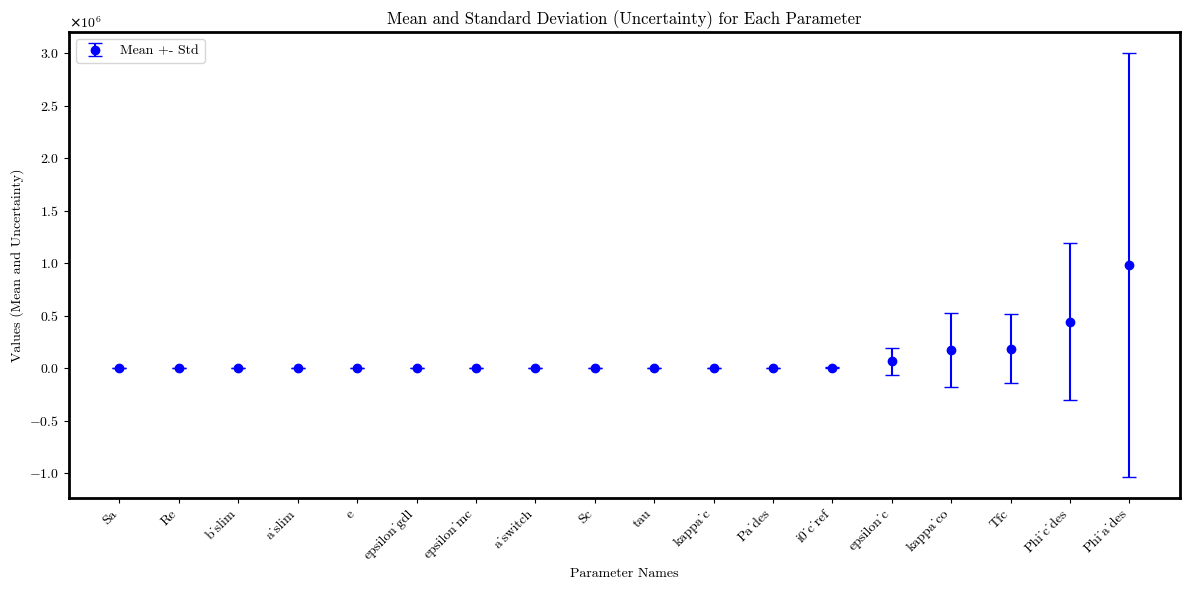

In [101]:
import matplotlib.pyplot as plt
import numpy as np

def plot_morris_results(morris_all):
    """
    Plots the Morris sensitivity analysis results.
    
    Parameters:
        morris_all (dict): Dictionary containing the sensitivity analysis results with keys
                            'names', 'mu_star', and 'mu_star_conf'.
    """
    # Data from the morris_all dictionary
    names = morris_all['names']
    mu = morris_all['mu_star']
    sigma = morris_all['mu_star_conf']

    # Sorting the parameters based on the mu_star values
    sorted_indices = np.argsort(mu)  # Get the indices that would sort mu_star
    names_sorted = names[sorted_indices]
    mu_sorted = mu[sorted_indices]
    sigma_sorted = sigma[sorted_indices]

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Error bars: mu as the central value, sigma as the uncertainty
    ax.errorbar(names_sorted, mu_sorted, yerr=sigma_sorted, fmt='o', color='b', label='Mean +- Std', capsize=5)

    # Set labels and title
    ax.set_xlabel('Parameter Names')
    ax.set_ylabel('Values (Mean and Uncertainty)')
    ax.set_title('Mean and Standard Deviation (Uncertainty) for Each Parameter')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Display the plot
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `morris_all` is a dictionary with the required data:
plot_morris_results(morris_all)


In [110]:
from SALib.analyze import morris as morris_analyze

morris_results = {}

for region in [1, 2, 3]:
    Y = data[f'Ucell_sum_region_{region}'].to_numpy()
    
    morris_result = morris_analyze.analyze(
        problem=problem,
        X=samples_df.to_numpy(),
        Y=Y,
        conf_level=0.95,
        num_levels=4,
        print_to_console=False
    )
    
    morris_results[f'region_{region}'] = morris_result


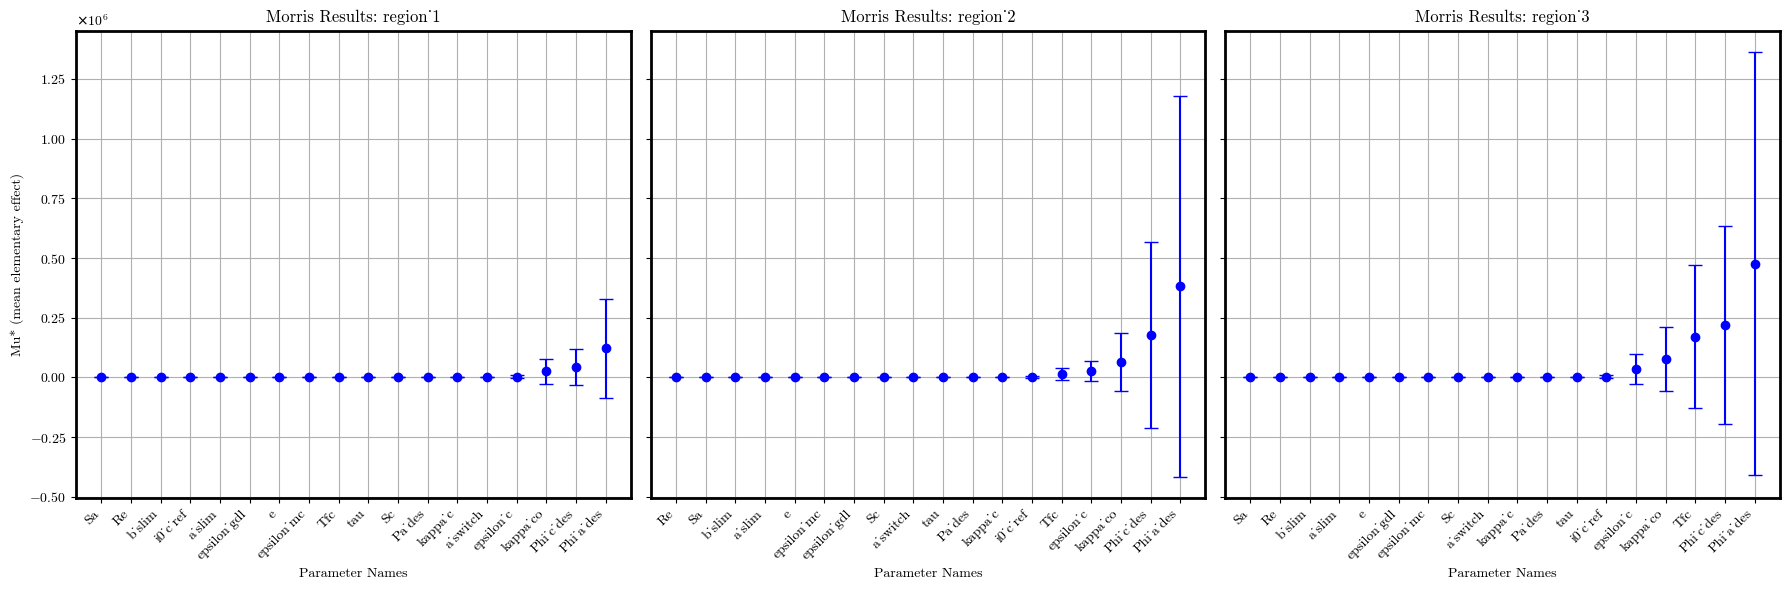

In [116]:
import matplotlib.pyplot as plt
import numpy as np

def plot_morris_results_all_regions(morris_results):
    """
    Plots the Morris sensitivity analysis results for all regions.

    Parameters:
        morris_results (dict): Dictionary where keys are region names ('region_1', etc.)
                               and values are Morris analysis dictionaries.
    """
    regions = list(morris_results.keys())
    num_regions = len(regions)
    
    fig, axes = plt.subplots(1, num_regions, figsize=(6 * num_regions, 6), sharey=True)

    if num_regions == 1:
        axes = [axes]  # Ensure axes is always iterable

    for ax, region in zip(axes, regions):
        result = morris_results[region]
        
        names = result['names']
        mu = result['mu_star']
        sigma = result['mu_star_conf']

        # Sort parameters
        sorted_indices = np.argsort(mu)
        names_sorted = np.array(names)[sorted_indices]
        mu_sorted = np.array(mu)[sorted_indices]
        sigma_sorted = np.array(sigma)[sorted_indices]

        # Plot
        ax.errorbar(names_sorted, mu_sorted, yerr=sigma_sorted, fmt='o', color='b', label='Mean ± Conf', capsize=5)
        ax.set_title(f'Morris Results: {region}')
        ax.set_xlabel('Parameter Names')
        ax.grid(True)

        # Rotate x-ticks
        ax.set_xticks(np.arange(len(names_sorted)))
        ax.set_xticklabels(names_sorted, rotation=45, ha='right')

    axes[0].set_ylabel('Mu* (mean elementary effect)')

    plt.tight_layout()
    plt.show()

# Example usage:
# morris_results = {'region_1': ..., 'region_2': ..., 'region_3': ...}
plot_morris_results_all_regions(morris_results)
